## Imports

In [2]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA

## Configuration and Constants

In [3]:
# Defining the constants and configurations used throughout the notebook.
iterations = 101000
on_remote = False
SUBS_data_filename = Path('/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_101000.npy') if on_remote else Path('C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_101000.npy')
k = 150
spinup = 1001
spacing = 1
p_train = 0.8

## Data Loading and Preprocessing

In [5]:
# Load the data and preprocess it for analysis.

# Load data from file
X_subs = np.load(SUBS_data_filename).astype('float32')

# Data preprocessing function
def generate_data(p_train, k, spinup, spacing, iterations, X_subs):
    """
    Generate training, validation, and test data from the provided dataset.
    
    Parameters:
    p_train (float): Percentage of data to be used for training.
    k (int): Time steps for prediction.
    spinup (int): Initial data to be ignored.
    spacing (int): Data spacing interval.
    iterations (int): Total number of iterations in the dataset.
    X_subs (numpy.array): The loaded dataset.

    Returns:
    tuple: Tuple containing training, validation, and test data.
    """
    N = iterations + 1
    n_train = int(np.round(p_train * (N - spinup)))
    n_val = int(np.round((1 - p_train)/2 * (N - spinup)))

    start, stop = spinup, spinup + n_train
    fit_x, fit_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, stop + n_val
    val_x, val_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, N
    prd_x, prd_y = slice(start, stop - k), slice(start + k, stop)

    # Data slicing
    X_train, Y_train = X_subs[fit_x], X_subs[fit_y]
    X_val, Y_val = X_subs[val_x], X_subs[val_y]
    X_test, Y_test = X_subs[prd_x], X_subs[prd_y]
        
    return X_train[::spacing], Y_train[::spacing], X_val[::spacing], Y_val[::spacing], X_test[::spacing], Y_test[::spacing]

# Generate the data
X_train, Y_train, X_val, Y_val, X_test, Y_test = generate_data(p_train, k, spinup, spacing, iterations, X_subs)


In [6]:
# Normalize function
def normalize_X(X, mean_data, std_data):
    """
    Normalize the data.

    Parameters:
    X (numpy.array): Data to be normalized.
    mean_data (float): Mean value for normalization.
    std_data (float): Standard deviation for normalization.

    Returns:
    numpy.array: Normalized data.
    """
    return (X - mean_data) / std_data

# Calculating mean and standard deviation for normalization
mean_data = X_train.mean()
std_data = X_train.std()

# Normalize data
X_train_normalized = normalize_X(X_train, mean_data, std_data)
Y_train_normalized = normalize_X(Y_train, mean_data, std_data)

X_val_normalized = normalize_X(X_val, mean_data, std_data)
Y_val_normalized = normalize_X(Y_val, mean_data, std_data)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-7.5263085 , -5.974635  , -4.4229617 , -2.871288  , -1.3196146 ,
         0.23205876,  1.7837322 ,  3.3354056 ,  4.8870792 ,  6.4387527 ,
         7.990426  ], dtype=float32),
 <a list of 4225 BarContainer objects>)

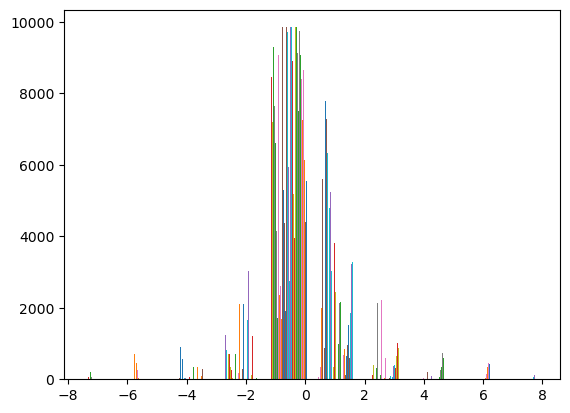

In [80]:
plt.hist(X_val_normalized)

## PCA Analysis

In [7]:
# Perform Principal Component Analysis (PCA) to understand the principal components of the data.

# Function for PCA analysis and reconstruction
def perform_pca(X_data, num_components):
    """
    Perform PCA analysis and reconstruct data using specified number of components.

    Parameters:
    X_data (numpy.array): Input data for PCA.
    num_components (int): Number of principal components to retain.

    Returns:
    tuple: Tuple containing transformed data and PCA object.
    """
    pca = PCA()
    X_transformed = pca.fit_transform(X_data)
    return X_transformed, pca

# Function for data reconstruction
def reconstruct_data(transformed_data, pca, l):
    """
    Reconstruct data using the first l components of PCA.

    Parameters:
    transformed_data (numpy.array): PCA transformed data.
    pca (PCA): PCA object.
    l (int): Number of components to use for reconstruction.

    Returns:
    numpy.array: Reconstructed data.
    """
    return np.dot(transformed_data[:, :l], pca.components_[:l, :]) + pca.mean_

# Function to calculate reconstruction error
def reconstruction_error(original_data, reconstructed_data):
    """
    Calculate the mean squared reconstruction error.

    Parameters:
    original_data (numpy.array): Original data.
    reconstructed_data (numpy.array): Reconstructed data.

    Returns:
    float: Mean squared error.
    """
    return np.mean(np.square(original_data - reconstructed_data))

def get_encoded(x, l):
    return x[:l]


In [8]:
# Perform PCA
latent_PCA, pca = perform_pca(X_train_normalized, num_components=4225)

In [9]:
# Select a specific l for demonstration
l = 100
X_train_reconstruced_PCA = reconstruct_data(latent_PCA, pca, l)
error = reconstruction_error(X_train_normalized, X_train_reconstruced_PCA)

print(f"Reconstruction Error for l={l}: {error}")

Reconstruction Error for l=100: 0.020069707185029984


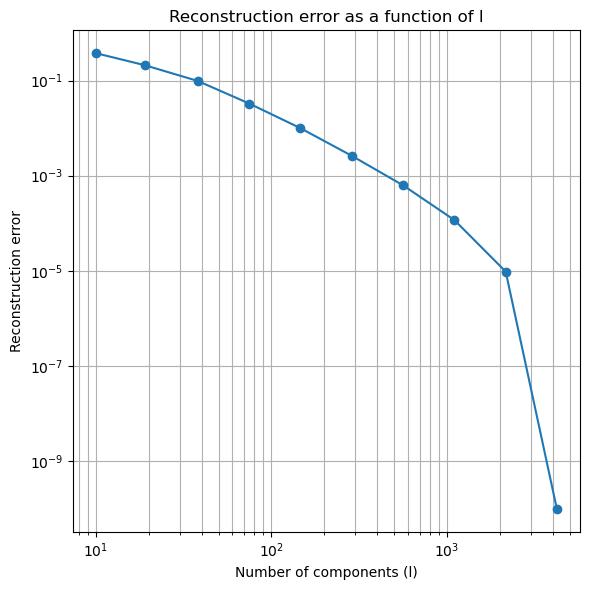

In [31]:
# Analyze reconstruction error for different number of components
l_values = [int(l) for l in np.logspace(1, np.log10(4225), 10)]
errors = [reconstruction_error(X_train_normalized, reconstruct_data(latent_PCA, pca, l)) for l in l_values]

# Plotting the reconstruction errors
plt.figure(figsize=(6,6))
plt.loglog(l_values, errors, marker='o')
plt.grid(True, 'both')
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()

0.9765238


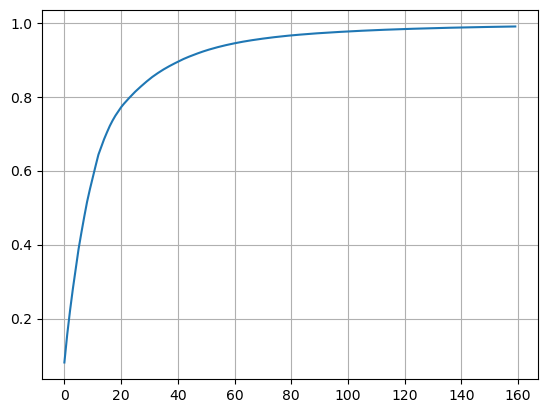

In [56]:
print(pca.explained_variance_ratio_.cumsum()[100])
plt.plot(pca.explained_variance_ratio_.cumsum()[:160])
plt.grid(which='both')

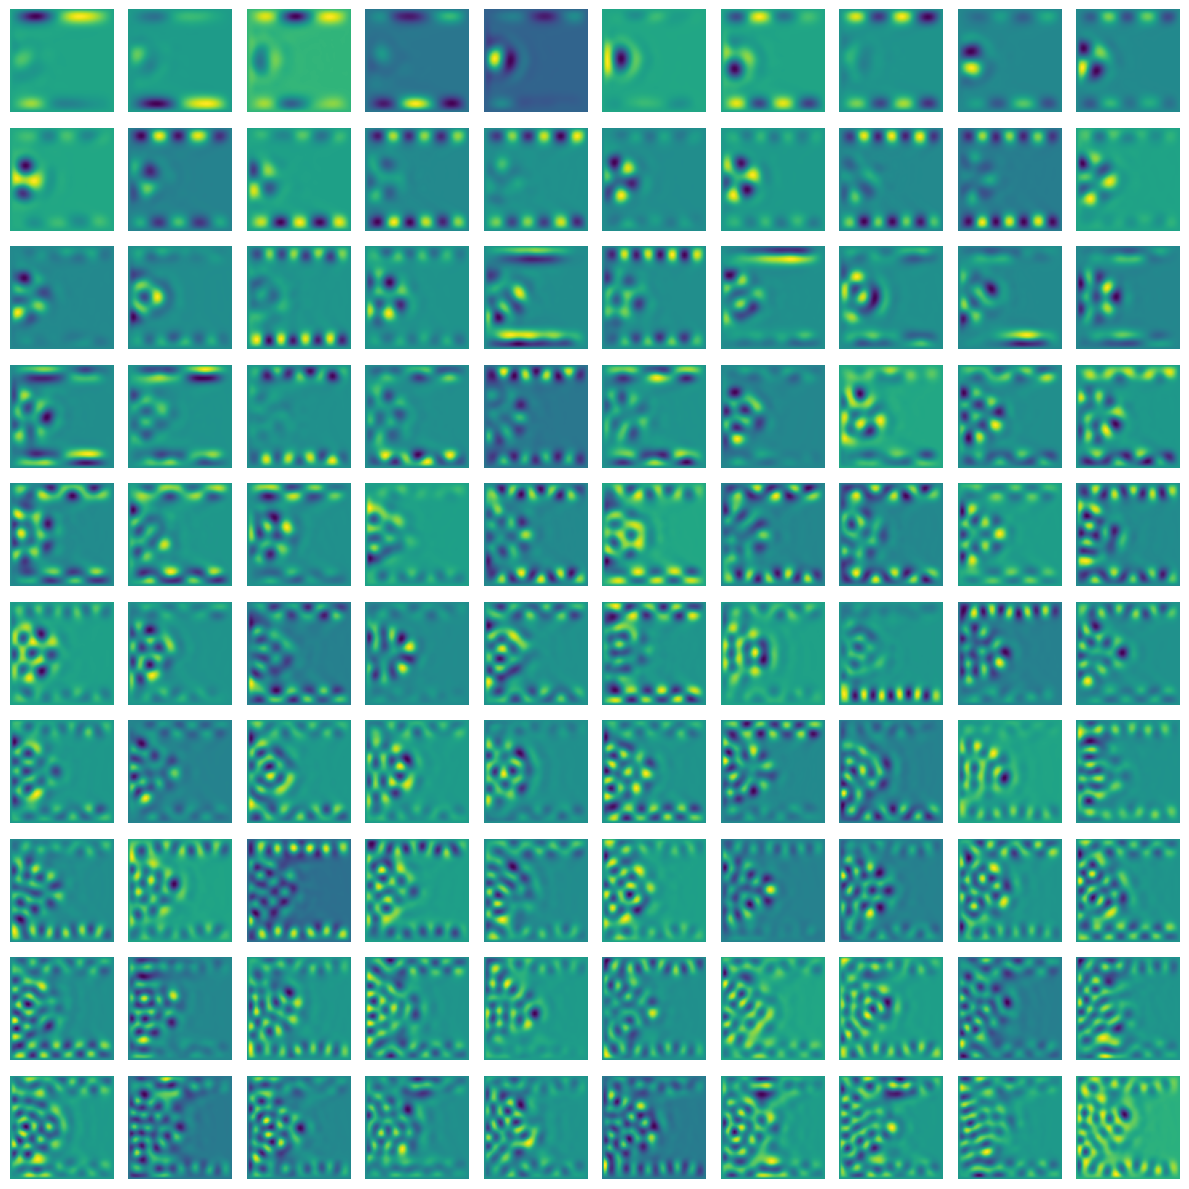

In [108]:
K = 100  # Number of components to 
bias_K = 0 # Bias to start from

fig, axs = plt.subplots(K//10, 10, figsize=(12, 12))
axs = axs.flatten()


for i in range(K):
    axs[i].imshow(pca.components_[i+bias_K, :].reshape(65, 65))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Autoencoder Implementation

In [10]:
# Implementing Autoencoders for feature extraction and data reconstruction.

# Function to convert data to PyTorch DataLoader
def create_dataloader(X_data, Y_data, batch_size, shuffle=True, ):
    """
    Convert data to PyTorch DataLoader.

    Parameters:
    X_data (numpy.array): Data to be converted.
    batch_size (int): Batch size for the DataLoader.
    shuffle (bool): Whether to shuffle the data.

    Returns:
    DataLoader: PyTorch DataLoader object.
    """
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    Y_tensor = torch.tensor(Y_data, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor, Y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create DataLoaders for training and validation data
batch_size = 32
train_loader = create_dataloader(X_train_normalized, Y_train_normalized, batch_size)
val_loader = create_dataloader(X_val_normalized, Y_val_normalized, batch_size, shuffle=False)

Using device: cuda:0


### Architectures

In [139]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[0], input_size),
        )
        self.apply(self.init_weights)

    @staticmethod  
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [10]:
class ConvAutoencoder(nn.Module):
    def __init__(self, filters):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        
        self.encoder = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),

            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
            self._block(self.filters, self.filters, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._block(self.filters, self.filters*2, stride=1),
            self._block(self.filters*2, self.filters*2, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._block(self.filters*2, self.filters*4, stride=1),
            self._block(self.filters*4, self.filters*4, stride=1),
            nn.Flatten(start_dim=1),

            nn.Linear(in_features=self.filters*4*16*16 ,out_features=100),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100,out_features=self.filters*4*16*16),
            nn.ReLU(True),
            nn.Unflatten(1,(self.filters*4, 16, 16)),
            self._block(self.filters*4, self.filters*4, stride=1),
            self._block(self.filters*4, self.filters*2, stride=1),
            nn.ConvTranspose2d(in_channels=self.filters*2, out_channels=self.filters*2, kernel_size=2, stride=2),
            self._block(self.filters*2, self.filters*2, stride=1),
            self._block(self.filters*2, self.filters, stride=1),
            nn.ConvTranspose2d(in_channels=self.filters, out_channels=self.filters, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.filters, out_channels=self.filters, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1),
            nn.Flatten(start_dim=1),
            )
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.InstanceNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [ ]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, filters):
        super(FullyConvolutionalAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = 2
        self.latent_dim = 100
        self.activation = nn.Sigmoid()

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
        ]

        for _ in range(self.no_downsamples):
            #encoder_layers.append(self._block(dim, dim, kernel_size=3, stride=1))
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            dim *= 2

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        encoder_layers.append(nn.Flatten(start_dim=1))
        encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        #encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))
            decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
            #decoder_layers.append(self._block(dim//2, dim//2, kernel_size=3, stride=1))
            dim //= 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [106]:
class FullyConvolutionalAutoencoder(nn.Module):
    def __init__(self, filters):
        super(FullyConvolutionalAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = 4
        self.latent_dim = 100

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=4, stride=2))
            dim *= 2
        
        encoder_layers.extend(self._block(dim, 6, kernel_size=3, stride=1))

        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = self._block(6, dim, kernel_size=3, stride=1)
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

#### PatchGAN

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.image_size = 65
        self.filters = 4
        
        self.model = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),

            # Input shape: (batch_size, in_channels, 65, 65)
            self._block(1, self.filters, normalize=False),
            self._block(self.filters, self.filters*2),
            self._block(self.filters*2, self.filters*4),
            #self._block(self.filters*4, self.filters*8),

            nn.Conv2d(self.filters*4, 1, kernel_size=4, stride=1, padding=1)
        )

        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        return self.model(x)


### Define network

In [86]:
linear_model = Autoencoder(input_size=4225, hidden_size=(100,))  # Example sizes
linear_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(linear_model.parameters(), lr=1e-3)

loss_values = []
val_loss_values = []

model = linear_model

In [11]:
conv_model = ConvAutoencoder(filters=16)  # Example sizes
conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = conv_model

In [86]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=8)  # Example sizes
fully_conv_model.to(device)

criterion = nn.L1Loss() #nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [ ]:
total_params = sum(p.numel() for p in fully_conv_model.parameters())
total_params_fc = sum(p.numel() for p in conv_model.parameters())

print(f"Total number of parameters in the model: {total_params}")
print("Architecture of fully_conv_model:")
#print(fully_conv_model)

print(f"Total number of parameters in the model: {total_params_fc}")
print("Architecture of conv_model:")
#print(conv_model)


### Training

#### Adversarial loss

In [135]:
# Initialize models
generator = FullyConvolutionalAutoencoder(filters=16).to(device)#ConvAutoencoder(filters=32).to(device)
discriminator = Discriminator().to(device)

# Loss functions
criterion_reconstruction = nn.MSELoss()  # Loss for reconstruction (Generator)
criterion_GAN = nn.MSELoss()            # Loss for GAN (Discriminator)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-3)

# Determining the size of image patches for the Discriminator
patch_height, patch_width = 65 // 2**3, 65 // 2**3
patch = (1, patch_height, patch_width)

loss_values = []

In [136]:
num_epochs = 100
lambda_g = 0.01

# Training loop
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    # Initialize cumulative losses for epoch
    cumulative_loss = {
        "generator": 0, "discriminator": 0, "reconstruction": 0,
        "fooling": 0
    }
    
    for img, _ in train_loader:
        valid_labels = torch.ones((img.size(0), *patch), device=device)
        fake_labels = torch.zeros((img.size(0), *patch), device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate reconstructed images
        reconstructed_images, latent = generator(img)

        # Fooling loss (Generator's success in fooling the Discriminator)
        predictions_from_fake = discriminator(reconstructed_images.detach())
        fooling_loss = criterion_GAN(predictions_from_fake, valid_labels)

        # Reconstruction loss (How similar the reconstructed and real images are)
        reconstruction_loss = criterion_reconstruction(reconstructed_images, img)

        # Total Generator loss
        generator_loss = reconstruction_loss + lambda_g * fooling_loss
        generator_loss.backward()
        optimizer_G.step()

        # Update cumulative losses
        cumulative_loss["generator"] += generator_loss.item()
        cumulative_loss["reconstruction"] += reconstruction_loss.item()
        cumulative_loss["fooling"] += fooling_loss.item()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images (Discriminator's ability to identify real images)
        predictions_from_real = discriminator(img)
        real_loss = criterion_GAN(predictions_from_real, valid_labels)

        # Loss for fake images (Discriminator's ability to identify fake images)
        predictions_from_fake = discriminator(reconstructed_images.detach())
        fake_loss = criterion_GAN(predictions_from_fake, fake_labels)   

        # Total Discriminator loss
        discriminator_loss = 0.5 * (real_loss + fake_loss)
        discriminator_loss.backward()
        optimizer_D.step()

        # Update cumulative losses
        cumulative_loss["discriminator"] += discriminator_loss.item()

    # Calculate average losses for the epoch
    avg_losses = {key: value / len(train_loader) for key, value in cumulative_loss.items()}
    loss_values.append(avg_losses)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}] - ' +
          f'Gen.: {avg_losses["generator"]:.4f}, ' +
          f'Recon.: {avg_losses["reconstruction"]:.4f}, ' +
          f'Fool.: {avg_losses["fooling"]:.4f}, ' +
          f'Disc.: {avg_losses["discriminator"]:.4f}, '
    )

# Plotting Losses
plt.figure(figsize=(10, 6))
for key in avg_losses:
    plt.semilogy([loss[key] for loss in loss_values][16:], label=f'{key} Loss')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/100] - Gen.: 0.3368, Recon.: 0.3321, Fool.: 0.4628, Disc.: 0.1545, 


KeyboardInterrupt: 

#### No regularization

In [107]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss() #
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

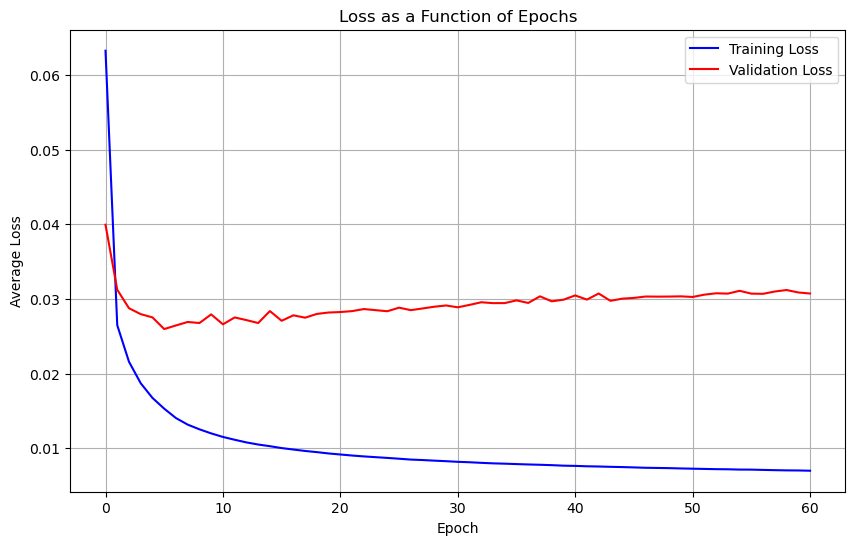

In [110]:
num_epochs = 10

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)
        loss = recon_loss 

        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot, label='Training Loss', color='blue')

plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

#### L1 Objective

In [14]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/100], Average Loss: 0.4399, Validation Loss: 0.7135
Epoch [2/100], Average Loss: 0.3568, Validation Loss: 0.4946
Epoch [3/100], Average Loss: 0.2991, Validation Loss: 0.2785
Epoch [4/100], Average Loss: 0.2033, Validation Loss: 0.1140
Epoch [5/100], Average Loss: 0.1560, Validation Loss: 0.0760
Epoch [6/100], Average Loss: 0.1368, Validation Loss: 0.0653
Epoch [7/100], Average Loss: 0.1255, Validation Loss: 0.0588
Epoch [8/100], Average Loss: 0.1176, Validation Loss: 0.0500
Epoch [9/100], Average Loss: 0.1120, Validation Loss: 0.0458
Epoch [10/100], Average Loss: 0.1071, Validation Loss: 0.0446
Epoch [11/100], Average Loss: 0.1031, Validation Loss: 0.0405
Epoch [12/100], Average Loss: 0.0996, Validation Loss: 0.0371
Epoch [13/100], Average Loss: 0.0970, Validation Loss: 0.0371
Epoch [14/100], Average Loss: 0.0947, Validation Loss: 0.0365
Epoch [15/100], Average Loss: 0.0929, Validation Loss: 0.0350
Epoch [16/100], Average Loss: 0.0911, Validation Loss: 0.0344
Epoch [17/100], A

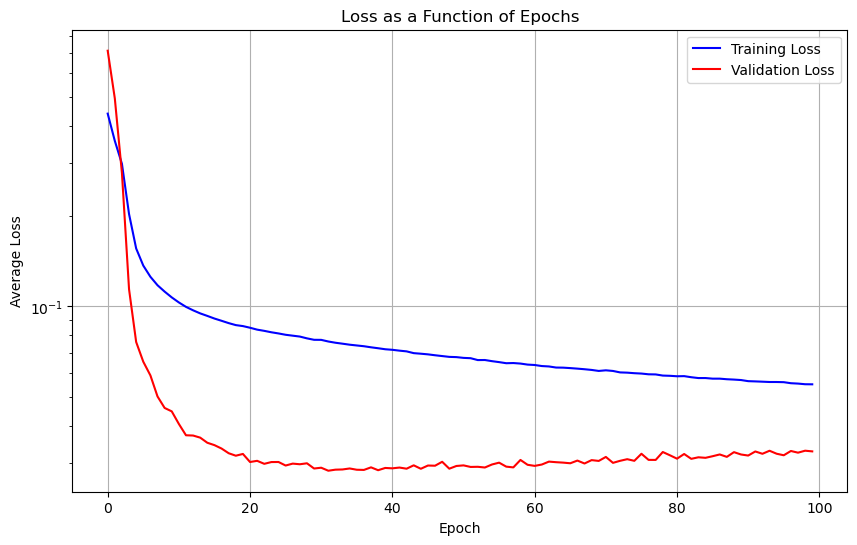

In [15]:
num_epochs = 100

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)
        loss = recon_loss 

        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = nn.MSELoss()(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot, label='Training Loss', color='blue')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Weight DEcay

In [16]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [17]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/100], Average Loss: 0.6069, Validation Loss: 0.4237
Epoch [2/100], Average Loss: 0.1985, Validation Loss: 0.1236
Epoch [3/100], Average Loss: 0.0811, Validation Loss: 0.0842
Epoch [4/100], Average Loss: 0.0592, Validation Loss: 0.0688
Epoch [5/100], Average Loss: 0.0494, Validation Loss: 0.0598
Epoch [6/100], Average Loss: 0.0458, Validation Loss: 0.0563
Epoch [7/100], Average Loss: 0.0414, Validation Loss: 0.0522
Epoch [8/100], Average Loss: 0.0391, Validation Loss: 0.0480
Epoch [9/100], Average Loss: 0.0374, Validation Loss: 0.0463
Epoch [10/100], Average Loss: 0.0359, Validation Loss: 0.0469
Epoch [11/100], Average Loss: 0.0345, Validation Loss: 0.0457
Epoch [12/100], Average Loss: 0.0340, Validation Loss: 0.0423
Epoch [13/100], Average Loss: 0.0326, Validation Loss: 0.0448
Epoch [14/100], Average Loss: 0.0324, Validation Loss: 0.0405
Epoch [15/100], Average Loss: 0.0311, Validation Loss: 0.0407
Epoch [16/100], Average Loss: 0.0305, Validation Loss: 0.0386
Epoch [17/100], A

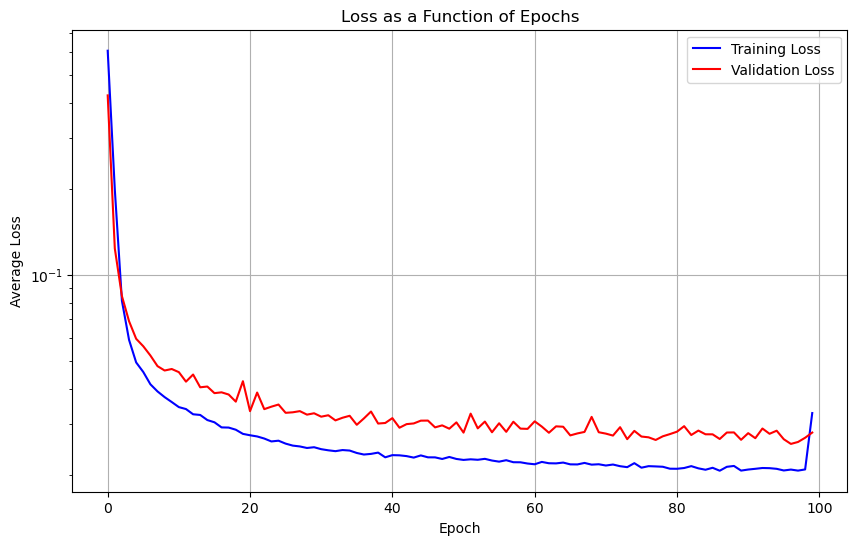

In [18]:
num_epochs = 100

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)
        loss = recon_loss 

        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot, label='Training Loss', color='blue')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

#### L2 reg

In [32]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/50], Average Loss: 0.3232, Reconstruction: 0.3113, L2: 0.0119, Validation Loss: 0.0887
Epoch [2/50], Average Loss: 0.0684, Reconstruction: 0.0565, L2: 0.0120, Validation Loss: 0.0543
Epoch [3/50], Average Loss: 0.0493, Reconstruction: 0.0374, L2: 0.0119, Validation Loss: 0.0399
Epoch [4/50], Average Loss: 0.0412, Reconstruction: 0.0294, L2: 0.0118, Validation Loss: 0.0347
Epoch [5/50], Average Loss: 0.0365, Reconstruction: 0.0248, L2: 0.0117, Validation Loss: 0.0292
Epoch [6/50], Average Loss: 0.0334, Reconstruction: 0.0219, L2: 0.0115, Validation Loss: 0.0285
Epoch [7/50], Average Loss: 0.0314, Reconstruction: 0.0201, L2: 0.0114, Validation Loss: 0.0243
Epoch [8/50], Average Loss: 0.0301, Reconstruction: 0.0188, L2: 0.0113, Validation Loss: 0.0244
Epoch [9/50], Average Loss: 0.0290, Reconstruction: 0.0177, L2: 0.0113, Validation Loss: 0.0220
Epoch [10/50], Average Loss: 0.0282, Reconstruction: 0.0170, L2: 0.0112, Validation Loss: 0.0226
Epoch [11/50], Average Loss: 0.0273, Re

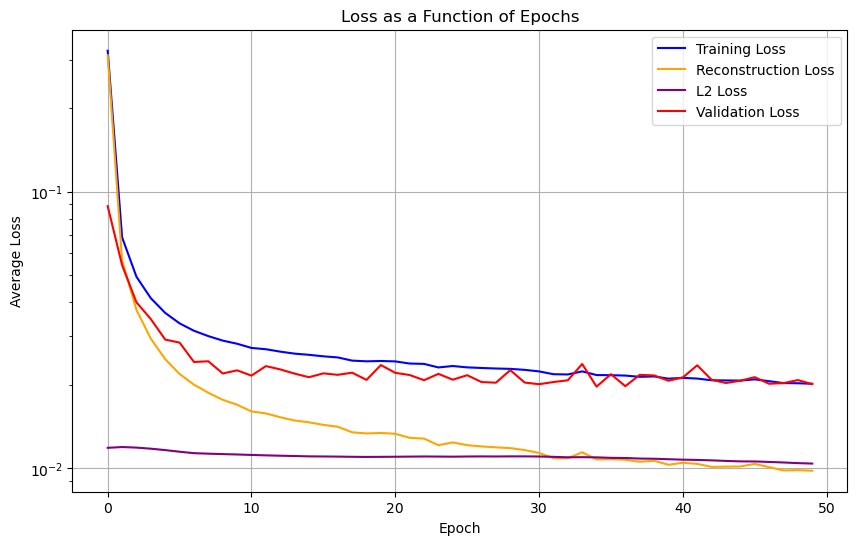

In [33]:
num_epochs = 50

# lambda_l1 = 0.001
lambda_l2 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    # total_l1_loss = 0
    total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        # l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2)

        l2_loss *= lambda_l2

        loss = recon_loss + l2_loss # + l1_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        # total_l1_loss += l1_loss.item()
        total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    # avg_l1_loss = total_l1_loss / len(train_loader)
    avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l2_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L2: {avg_l2_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='L2 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

#### L1

In [154]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [155]:
num_epochs = 50

lambda_l1 = 0.0001
# lambda_l2 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    total_l1_loss = 0
    #total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        #l2_loss = 0
        #for param in model.parameters():
        #    l2_loss += torch.norm(param, 2)

        #l2_loss *= lambda_l2

        loss = recon_loss + l1_loss # + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        #total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    # avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='L1 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/50], Average Loss: 0.3018, Reconstruction: 0.2766, L1: 0.0251, Validation Loss: 0.1002
Epoch [2/50], Average Loss: 0.0635, Reconstruction: 0.0546, L1: 0.0089, Validation Loss: 0.0611


KeyboardInterrupt: 

#### L1 and L2

In [41]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/50], Average Loss: 0.3341, Reconstruction: 0.2935, L1: 0.0288, L2: 0.0118, Validation Loss: 0.0943
Epoch [2/50], Average Loss: 0.0853, Reconstruction: 0.0628, L1: 0.0105, L2: 0.0119, Validation Loss: 0.0616
Epoch [3/50], Average Loss: 0.0585, Reconstruction: 0.0419, L1: 0.0046, L2: 0.0120, Validation Loss: 0.0491
Epoch [4/50], Average Loss: 0.0479, Reconstruction: 0.0331, L1: 0.0029, L2: 0.0119, Validation Loss: 0.0380
Epoch [5/50], Average Loss: 0.0419, Reconstruction: 0.0277, L1: 0.0023, L2: 0.0119, Validation Loss: 0.0334
Epoch [6/50], Average Loss: 0.0388, Reconstruction: 0.0250, L1: 0.0020, L2: 0.0119, Validation Loss: 0.0326
Epoch [7/50], Average Loss: 0.0361, Reconstruction: 0.0224, L1: 0.0019, L2: 0.0118, Validation Loss: 0.0276
Epoch [8/50], Average Loss: 0.0350, Reconstruction: 0.0214, L1: 0.0017, L2: 0.0118, Validation Loss: 0.0259
Epoch [9/50], Average Loss: 0.0331, Reconstruction: 0.0197, L1: 0.0016, L2: 0.0118, Validation Loss: 0.0265
Epoch [10/50], Average Loss:

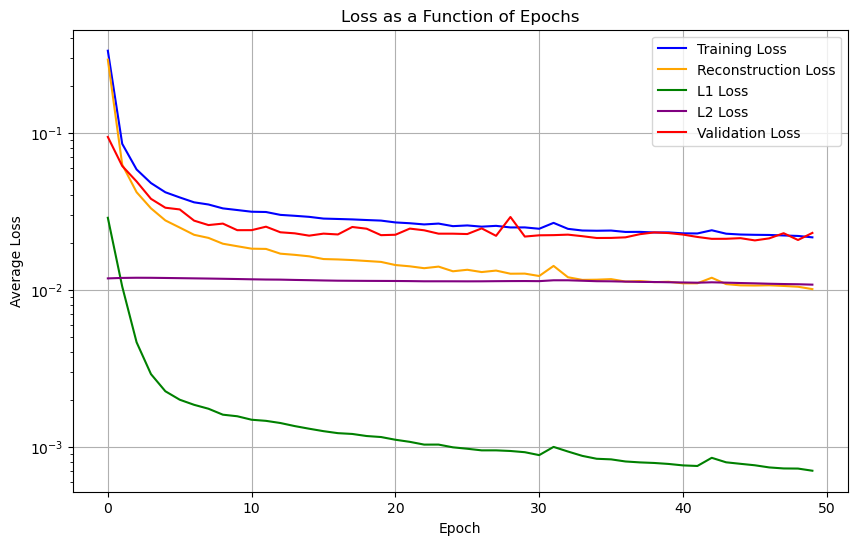

In [42]:
num_epochs = 50

lambda_l1 = 0.0001
lambda_l2 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    total_l1_loss = 0
    total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2)

        l2_loss *= lambda_l2

        loss = recon_loss + l1_loss + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss, avg_l2_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, L2: {avg_l2_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='L1 Loss', color='green')
plt.semilogy(loss_plot[:,3], label='L2 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Temporal Loss

In [8]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [148]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

# Load the model state from the .pth file
fully_conv_model.load_state_dict(torch.load('all_data.pth'))
model = fully_conv_model

In [162]:
best_val_loss = float('inf')

lambda_l1 = 0
lambda_temp = 0#0.01

num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_l1_loss = 0
    total_train_loss_reconstruction = 0
    total_train_loss_temporal = 0
    
    for current_state, next_state in train_loader:
        current_reconstruction, current_latent = model(current_state)
        next_reconstruction, next_latent = model(next_state)
        
        loss_temporal = lambda_temp * criterion(current_latent, next_latent)
        
        loss_reconstruction = 1 * (criterion(current_reconstruction, current_state))# + \
                              #criterion(next_reconstruction, next_state))
        
        loss_l1 = lambda_l1 * 0.5 * (torch.mean(torch.norm(current_latent, 1, dim=1)) + \
                               torch.mean(torch.norm(next_latent, 1, dim=1)))

        loss = loss_reconstruction + loss_temporal
        
        total_train_loss += loss.item()
        total_train_loss_reconstruction += loss_reconstruction.item()
        total_train_loss_temporal += loss_temporal.item()
        total_l1_loss += loss_l1.item()

        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

    total_train_loss_reconstruction /= len(train_loader)
    total_train_loss_temporal /= len(train_loader)
    total_train_loss /= len(train_loader)
    total_l1_loss /= len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output,_ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([total_train_loss, total_train_loss_reconstruction, total_train_loss_temporal, total_l1_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_train_loss:.4f}, Reconstruction: {total_train_loss_reconstruction:.4f}, Temporal: {total_train_loss_temporal:.4f}, L1 Loss: {avg_l1_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='Temporal Loss', color='green')
plt.semilogy(loss_plot[:,3], label='L1 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/50], Average Loss: 3.0962, Reconstruction: 3.0962, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.2051
Epoch [2/50], Average Loss: 3.0961, Reconstruction: 3.0961, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.2097
Epoch [3/50], Average Loss: 3.0961, Reconstruction: 3.0961, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.1898
Epoch [4/50], Average Loss: 3.0960, Reconstruction: 3.0960, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.2056
Epoch [5/50], Average Loss: 3.0961, Reconstruction: 3.0961, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.2083
Epoch [6/50], Average Loss: 3.0960, Reconstruction: 3.0960, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.2463
Epoch [7/50], Average Loss: 3.0962, Reconstruction: 3.0962, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.1963
Epoch [8/50], Average Loss: 3.0961, Reconstruction: 3.0961, Temporal: 0.0000, L1 Loss: 0.0089, Validation Loss: 3.1960


KeyboardInterrupt: 

#### KL

In [9]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [22]:
list(list(model.children())[0].children())[3]

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [ ]:
def kl_divergence(rho, rho_hat):
    """
    Calculate the Kullback-Leibler divergence between two Bernoulli distributions.

    Parameters:
    rho (torch.Tensor): Mean of the first Bernoulli distribution.
    rho_hat (torch.Tensor): Mean of the second Bernoulli distribution.

    Returns:
    torch.Tensor: KL divergence between the two Bernoulli distributions.
    """
    term_one = rho * torch.log(rho / rho_hat)
    term_two = (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    return torch.sum(term_one + term_two)

def kl_divergence(self, activations):
    rho = 0.05  # Sparsity parameter, you can adjust this
    rho_hat = torch.mean(activations, 0)  # Average over batch
    kl_div = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    return torch.sum(kl_div)

In [25]:
def get_modules(model):
    modules = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            modules.append(module)
    return modules

model_children = get_modules(model)
model_children

[Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Linear(in_features=16384, out_features=100, bias=True),
 Linear(in_features=100, out_features=16384, bias=True),
 Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [27]:
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(F.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))
# define the sparse loss function

def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

In [28]:
num_epochs = 50

#lambda_l1 = 0.0001
# lambda_l2 = 0.0001
lambda_kl = 0.01
rho = 0.05

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    #total_l1_loss = 0
    #total_l2_loss = 0
    total_kl_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        #l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        #l2_loss = 0
        #for param in model.parameters():
        #    l2_loss += torch.norm(param, 2)

        #l2_loss *= lambda_l2

        kl_loss = lambda_kl * sparse_loss(rho, img)

        loss = recon_loss + kl_loss # + l1_loss # + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item() 
        #total_l1_loss += l1_loss.item()
        #total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    #avg_l1_loss = total_l1_loss / len(train_loader)
    # avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_kl_loss = total_kl_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_kl_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='KL Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 4225]

#### Cont. Latent space

In [ ]:
num_epochs = 50
lambda_l1 = 0.001
lambda_cont = 0.01
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_recon_loss = 0
    total_l1_loss = 0
    total_cont_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        recon_loss = criterion(output, img)

        cont_loss = lambda_cont * criterion(activations[:-1], activations[1:])

        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        loss = recon_loss + l1_loss + cont_loss

        total_train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        total_cont_loss += cont_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    avg_cont_loss = total_cont_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss, avg_cont_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Cont: {avg_cont_loss:.4f}')
# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.loglog(loss_plot[:,0], label='Training Loss', color='blue')
plt.loglog(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.loglog(loss_plot[:,2], label='Regularization Loss', color='green')
plt.loglog(loss_plot[:,3], label='Continuity Loss', color='purple')

plt.loglog(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## Evaluation of PCA and Autoencoder Models

In [66]:
# Evaluating the performance of the PCA and Autoencoder models on the validation set.

# Function for model evaluation
def evaluate_model(model, selected_loader, criterion, pca, l):
    """
    Evaluate the model performance.

    Parameters:
    model (nn.Module): PyTorch model to evaluate.
    X_data (numpy.array): Data to evaluate the model on.
    criterion (function): Loss function.
    pca (PCA): PCA object.
    l (int): Number of PCA components.

    Returns:
    tuple: Tuple containing reconstruction errors for PCA and Autoencoder.
    """

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_ae_loss = 0
    total_pca_loss = 0
    with torch.no_grad():
        for data in selected_loader:
            img, _ = data

            X_AE_reconstructed, _ = model(img)
            total_ae_loss += criterion(X_AE_reconstructed, img).item()

            X_PCA_reconstructed = reconstruct_data(pca.transform(img.cpu().numpy()), pca, l)
            total_pca_loss += criterion(torch.tensor(X_PCA_reconstructed).to(device), img).item()

    avg_pca_loss = total_pca_loss / len(selected_loader)
    avg_ae_loss = total_ae_loss / len(selected_loader)

    return avg_pca_loss, avg_ae_loss

# Evaluate the models
error_pca, error_ae = evaluate_model(model, val_loader, nn.MSELoss(), pca, l=200)
print(f"PCA Reconstruction Error: {error_pca}, Autoencoder Reconstruction Error: {error_ae}")

PCA Reconstruction Error: 0.0063377478032965555, Autoencoder Reconstruction Error: 0.007511718795852518


## Visualization

In [43]:
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32).to(device)  # Convert to tensor
#X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
cmap = 'viridis'
choose_random = True
choose_val = True
X_chosen = X_val_tensor if choose_val else X_train_tensor
#model = generator

In [46]:
def get_images(random_index, X=X_chosen):
    model.eval()

    l = 200
    X_transformed = pca.transform(X.cpu().detach().numpy())
    X_PCA = reconstruct_data(X_transformed, pca, l)
    
    image_shape = (65, 65)  # Replace with the actual shape of your images
    latent_shape = (10, 10)  # Replace with the actual shape of your images

    img_train = X.cpu().detach().numpy()[random_index].reshape(image_shape)
    img_train_next = X.cpu().detach().numpy()[random_index+1].reshape(image_shape)

    img_pca = X_PCA[random_index].reshape(image_shape)
    img_pca_next = X_PCA[random_index+1].reshape(image_shape)

    img_ae = model(X[random_index].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)
    img_ae_next = model(X[random_index+1].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)

    img_pca_enc = get_encoded(X_PCA[random_index], l)
    img_pca_enc_next = get_encoded(X_PCA[random_index+1],l)

    img_ae_enc = model.encoder(X[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()
    img_ae_enc_next = model.encoder(X[random_index+1].unsqueeze(0)).cpu().detach().numpy().flatten()

    return img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next

In [41]:
def get_images_test(selected_loader, l=100):

    model.eval()
    for data in selected_loader:
        img, img_next = data
        break
    
    image_shape = (65, 65)  # Replace with the actual shape of your images

    img_train = img[0].cpu().detach().numpy().reshape(image_shape)
    img_train_next = img_next[0].cpu().detach().numpy().reshape(image_shape)

    img_ae = model(img[0].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)
    print(img[0].cpu().detach().numpy())
    img_ae_next = model(img_next[0].unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)

    X_transformed = pca.transform(np.array([img[0].cpu().detach().numpy(), img_next[0]]))
    img_pca = reconstruct_data(X_transformed[0], pca, l).reshape(image_shape)

    img_pca_next = reconstruct_data(X_transformed[1], pca, l).reshape(image_shape)
    
    return img_train, img_train_next, img_ae, img_ae_next, img_pca, img_pca_next

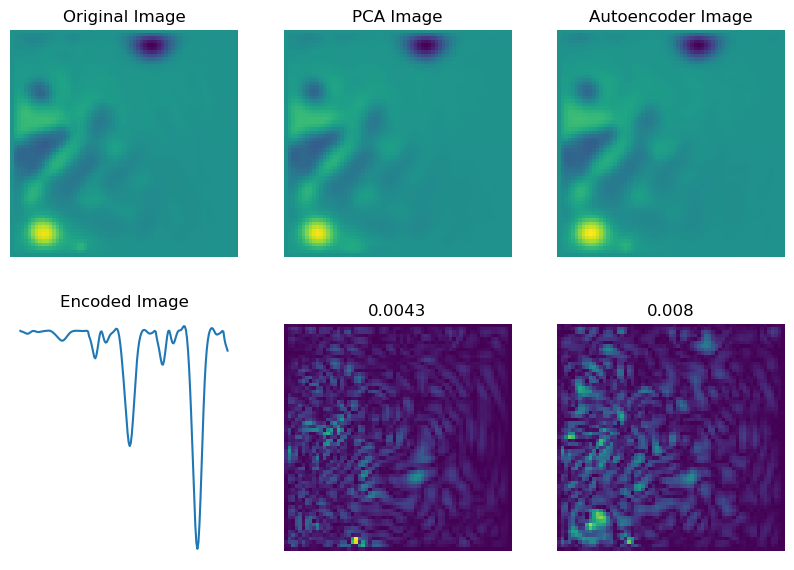

In [63]:
if choose_random:
    random_index = np.random.randint(len(X_val))
    img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(random_index=random_index)

vmin = min(img_pca.min(), img_train.min(), img_ae.min())
vmax = max(img_pca.max(), img_train.max(), img_ae.max())

#cmap = 'Greys'

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'Autoencoder Image')
axes[0,2].axis('off')

axes[1,0].plot(img_pca_enc.flatten())
axes[1,0].set_title('Encoded Image')
axes[1,0].axis('off')

#vmin_diff = min((img_pca-img_train).min(), (img_ae-img_train).min())
vmax_diff = max((np.abs(img_pca-img_train)).max(), (np.abs(img_ae-img_train)).max())

axes[1,1].imshow(np.abs(img_pca- img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_PCA = np.round(reconstruction_error(img_train, img_pca),4)
axes[1,1].set_title(f'{str(er_PCA)}')
axes[1,1].axis('off')

axes[1,2].imshow(np.abs(img_ae-img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_AE = np.round(reconstruction_error(img_train, img_ae), 4)
axes[1,2].set_title(f'{str(er_AE)}')
axes[1,2].axis('off')

plt.show()

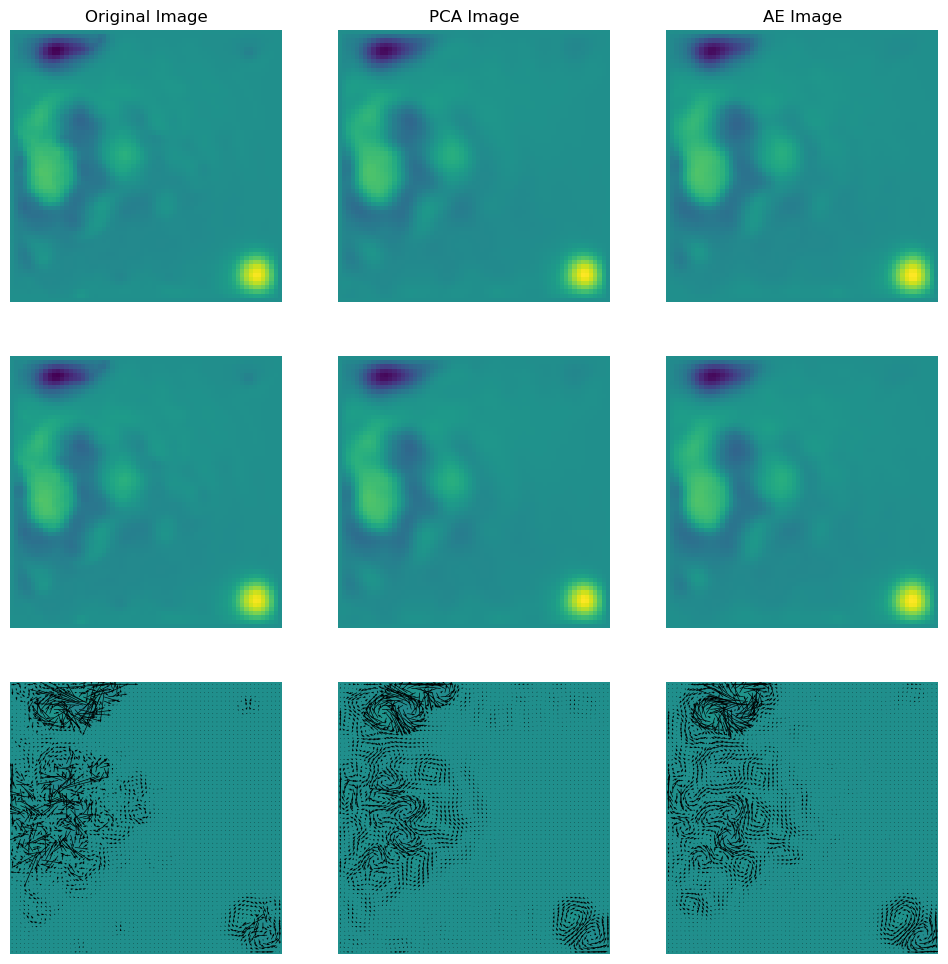

In [52]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(random_index=random_index, X=X_chosen)


vmin = min(img_pca.min(), img_train.min(), img_train_next.min(), img_pca_next.min())
vmax = max(img_pca.max(), img_train.max(), img_train_next.max(), img_pca_next.max())

fig, axes = plt.subplots(3,3, figsize=(12, 12))

# Train
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[1,0].imshow(img_train_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,0].axis('off')

gradient_x, gradient_y = np.gradient(img_train_next - img_train)
X, Y = np.meshgrid(np.arange(gradient_x.shape[1]), np.arange(gradient_y.shape[0]))
axes[2,0].imshow(img_train_next - img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,0].quiver(X, Y, gradient_x, gradient_y)
axes[2,0].axis('off')


# PCA
axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[1,1].imshow(img_pca_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,1].axis('off')

# Compute the difference
difference = img_pca_next - img_pca
gradient_x, gradient_y = np.gradient(difference)
axes[2,1].imshow(img_pca_next - img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,1].quiver(X, Y, gradient_x, gradient_y)
axes[2,1].axis('off')

# AE
axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'AE Image')
axes[0,2].axis('off')

axes[1,2].imshow(img_ae_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,2].axis('off')

# Compute the difference
difference = img_ae_next - img_ae
gradient_x, gradient_y = np.gradient(difference)
axes[2,2].imshow(img_ae_next - img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,2].quiver(X, Y, gradient_x, gradient_y)
axes[2,2].axis('off')


plt.show()

In [ ]:
v

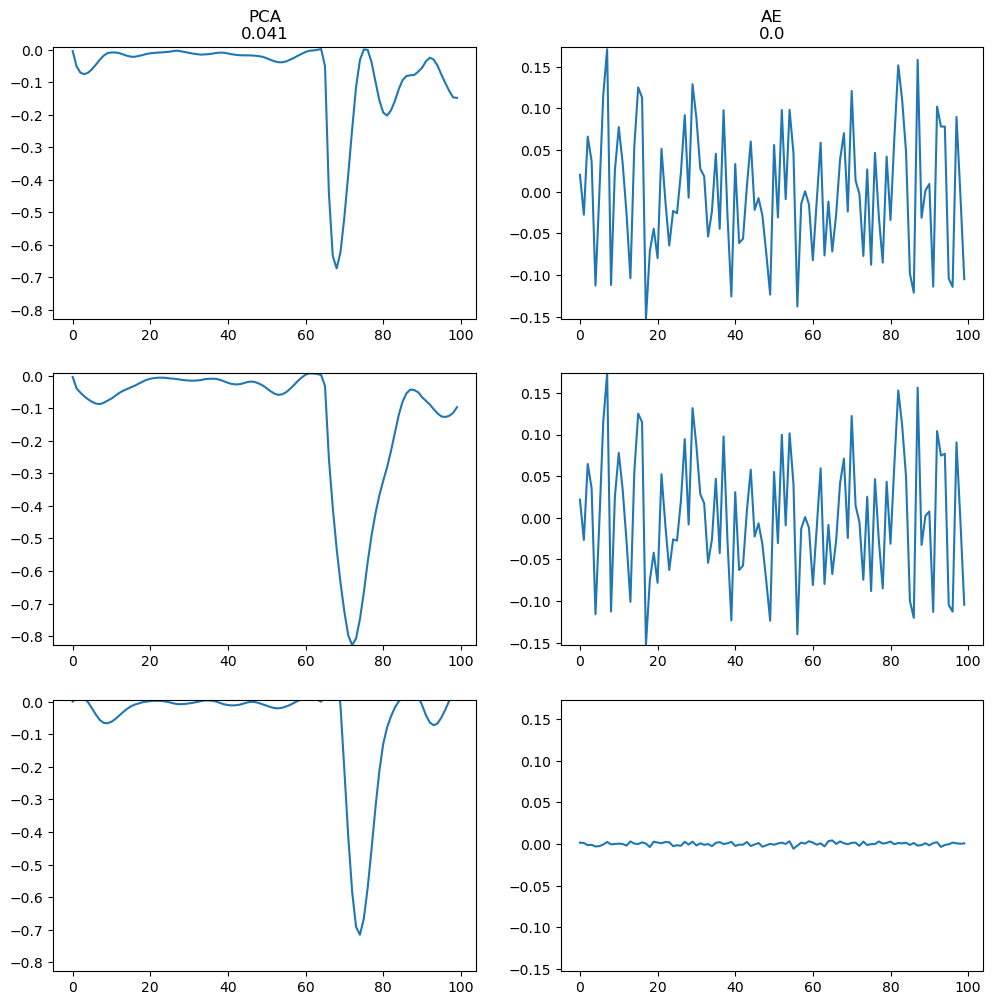

In [127]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(random_index=random_index, X=X_chosen)


vmin_pca = min(img_pca_enc.min(), img_pca_enc_next.min())
vmax_pca = max(img_pca_enc.max(), img_pca_enc_next.max())

err_pca = str(np.round(np.mean(((img_pca_enc_next - img_pca_enc)/(vmax_pca - vmin_pca))**2),4))

vmin_ae = min(img_ae_enc.min(), img_ae_enc_next.min())
vmax_ae = max(img_ae_enc.max(), img_ae_enc_next.max())

err_ae = str(np.round(np.mean(((img_ae_enc_next - img_ae_enc)/(vmax_ae - vmin_ae))**2),4))

fig, axes = plt.subplots(3,2, figsize=(12, 12))

axes[0,0].plot(img_pca_enc)
axes[0,0].set_title(f'PCA\n{err_pca}')
axes[0,0].set_ylim([vmin_pca, vmax_pca])

axes[1,0].plot(img_pca_enc_next)
axes[1,0].set_ylim([vmin_pca, vmax_pca])

axes[2,0].plot(img_pca_enc_next - img_pca_enc)
axes[2,0].set_ylim([vmin_pca, vmax_pca])


axes[0,1].plot(img_ae_enc)
axes[0,1].set_title(f'AE\n{err_ae}')
axes[0,1].set_ylim([vmin_ae, vmax_ae])
axes[1,1].plot(img_ae_enc_next)
axes[1,1].set_ylim([vmin_ae, vmax_ae])
axes[2,1].plot(img_ae_enc_next - img_ae_enc)
axes[2,1].set_ylim([vmin_ae, vmax_ae])


plt.show()


## Latent space visuals

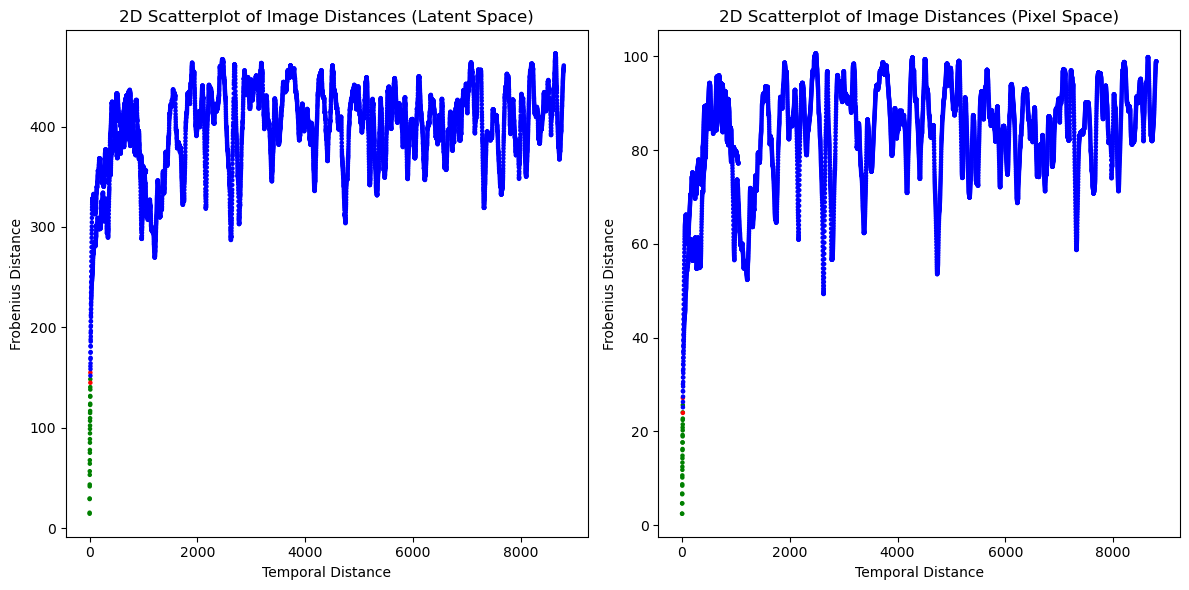

In [53]:
# Fix a random image index
random_image_index = np.random.randint(len(X_val_normalized))

# Get the latent representation of the random image
random_image_latent = model.encoder(X_val_tensor[random_image_index].unsqueeze(0)).cpu().detach().numpy().flatten()
random_image = X_val_normalized[random_image_index]


# Calculate the distances between the random image's latent representation and all other latent representations
latent_distances = []
temporal_distances = []
frobenius_distances = []

for i, image in enumerate(X_val_normalized):
    if i != random_image_index:
        image_latent = model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten()

        frobenius_distance = np.linalg.norm(random_image - image)
        latent_distance = np.linalg.norm(random_image_latent - image_latent)
        temporal_distance = abs(random_image_index - i)

        latent_distances.append(latent_distance)
        temporal_distances.append(temporal_distance)
        frobenius_distances.append(frobenius_distance)

# Plot the scatterplot
K_color = 15  # Threshold for coloring points
colors = ['green' if d < K_color else 'red' if d == K_color else 'blue' for d in temporal_distances]

plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

# Plot the first scatterplot
plt.subplot(1, 2, 1)
plt.scatter(temporal_distances, latent_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.xlabel('Temporal Distance')
plt.ylabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances (Latent Space)')

# Plot the second scatterplot
plt.subplot(1, 2, 2)
plt.scatter(temporal_distances, frobenius_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.xlabel('Temporal Distance')
plt.ylabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances (Pixel Space)')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


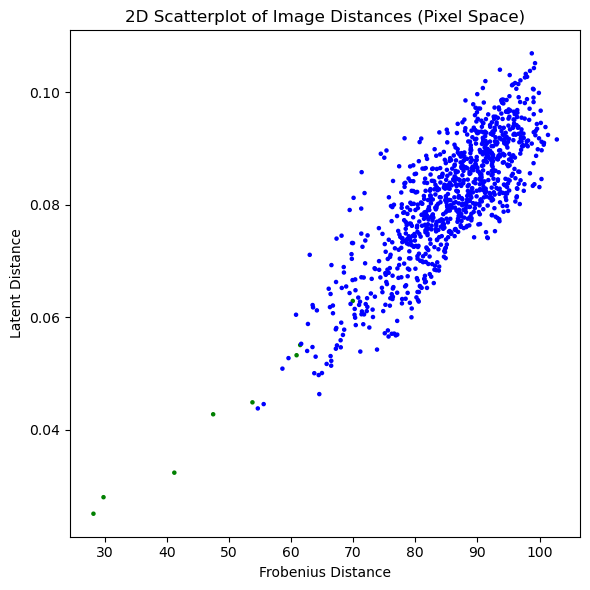

In [129]:
# Fix a random image index
random_image_index = np.random.randint(len(X_val_normalized))

# Get the latent representation of the random image
random_image_latent = model.encoder(X_val_tensor[random_image_index].unsqueeze(0)).cpu().detach().numpy().flatten()
random_image = X_val_normalized[random_image_index]


# Calculate the distances between the random image's latent representation and all other latent representations
latent_distances = []
temporal_distances = []
frobenius_distances = []

for i, image in enumerate(X_val_normalized):
    if i != random_image_index:
        image_latent = model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten()

        frobenius_distance = np.linalg.norm(random_image - image)
        latent_distance = np.linalg.norm(random_image_latent - image_latent)
        temporal_distance = abs(random_image_index - i)

        latent_distances.append(latent_distance)
        temporal_distances.append(temporal_distance)
        frobenius_distances.append(frobenius_distance)

# Plot the scatterplot
K_color = 5  # Threshold for coloring points
colors = ['green' if d < K_color else 'blue' for d in temporal_distances]

plt.figure(figsize=(6, 6))  # Adjust the figure size as desired

plt.scatter(frobenius_distances, latent_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.ylabel('Latent Distance')
plt.xlabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances')

plt.title('2D Scatterplot of Image Distances (Pixel Space)')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


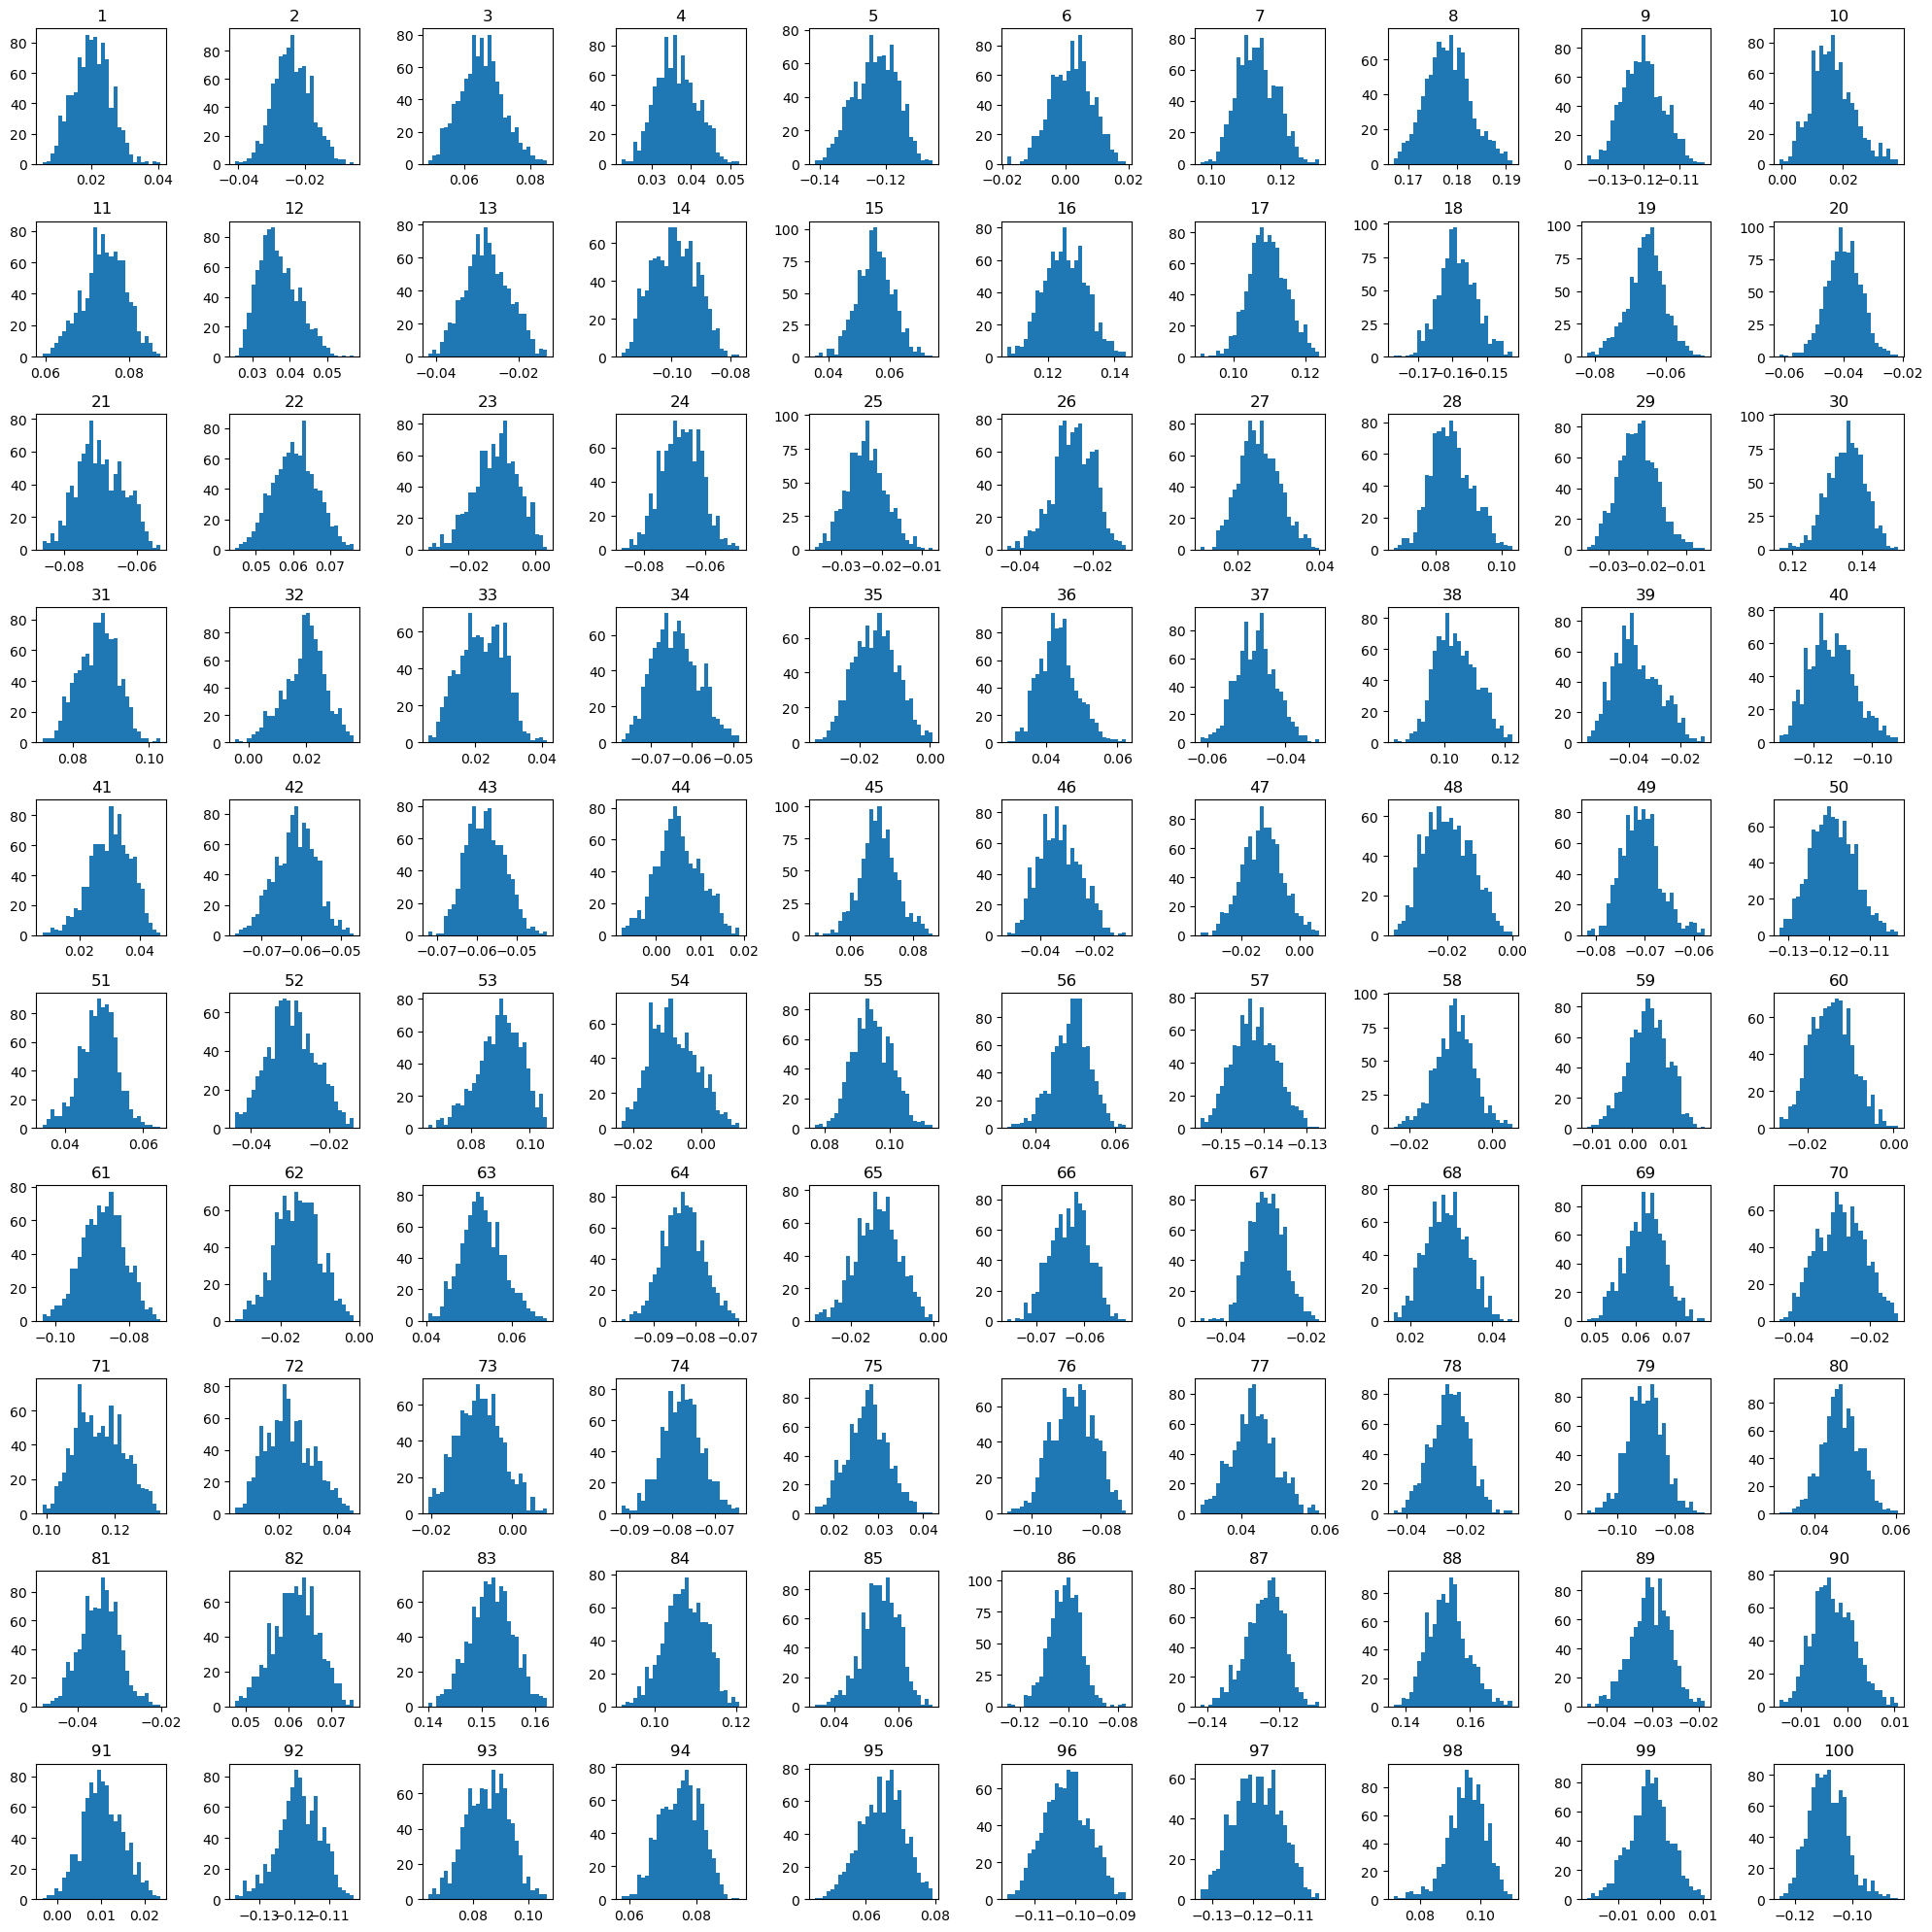

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Get the latent representations of all images in the validation set
latent_representations = []
for i, image in enumerate(X_val_normalized):
    latent_representations.append(model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten())

# Calculate the histogram for each direction in the latent space
histograms = []
bins_list = []
for i in range(latent_representations[0].shape[0]):
    values = [latent[i] for latent in latent_representations]
    histogram, bins = np.histogram(values, bins=30)
    histograms.append(histogram)
    bins_list.append(bins)

# Create the subplot
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

# Plot the histograms in the subplot
for i in range(10):
    for j in range(10):
        bins = bins_list[i*10+j]
        axs[i, j].bar(bins[:-1], histograms[i*10+j], width=(bins[1]-bins[0]))
        axs[i, j].set_title(f'{i*10+j+1}')
        #axs[i, j].set_xlabel('Latent Value')
        #axs[i, j].set_ylabel('Frequency')
        #axs[i, j].set_xlim([-0.15, 0.15])

plt.tight_layout()
plt.show()


In [100]:
np.array([latent[i] for latent in latent_representations]).shape

(985,)

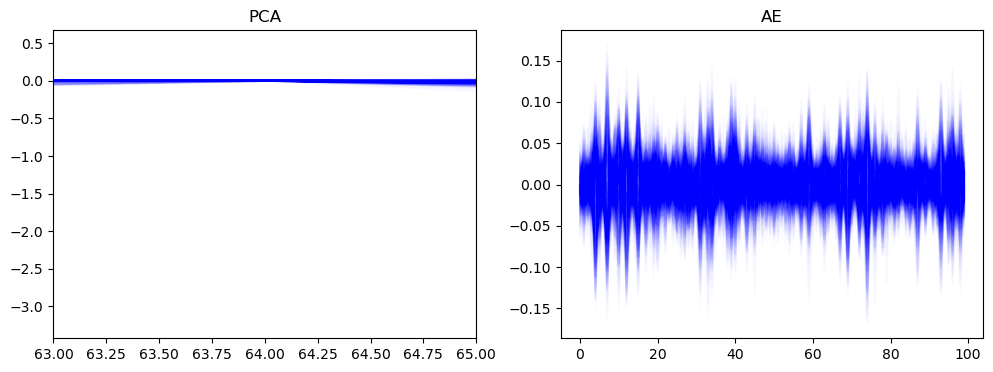

In [101]:
model.eval()

l = 100

cmap = 'viridis'
random_index = np.random.randint(len(X_val))

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].set_title(f'PCA')
axes[1].set_title(f'AE')

for i in range(len(X_val)):
    random_index = i
    img_pca_enc = get_encoded(X_PCA_test[random_index], l)
    #img_pca_enc_next = get_encoded(X_PCA_test[random_index+1],l)

    img_ae_enc = model.encoder(X_val_tensor[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()
    #img_ae_enc_next = model.encoder(X_val_tensor[random_index+1].unsqueeze(0)).cpu().detach().numpy().flatten()

    axes[0].plot(img_pca_enc, alpha=0.01, color='blue')

    axes[1].plot(img_ae_enc, alpha=0.01, color='blue')

axes[0].set_xlim([63,65])
plt.show()
random_index = 0


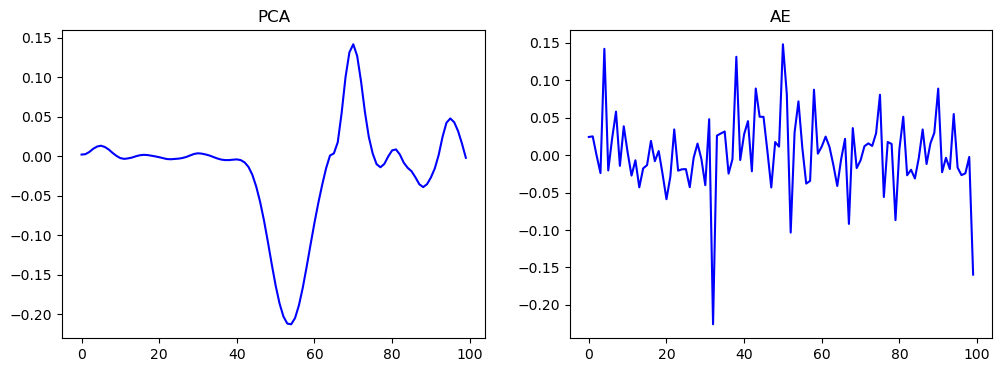

In [50]:
model.eval()

l = 100

cmap = 'viridis'

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].set_title(f'PCA')
axes[1].set_title(f'AE')

#random_index = 0

random_index += 1
img_pca_enc = get_encoded(X_PCA_test[random_index], l)

img_ae_enc = model.encoder(X_val_tensor[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()

axes[0].plot(img_pca_enc, color='blue')
axes[1].plot(img_ae_enc, color='blue')

plt.show()


### CNN Visualizer

TypeError: Invalid shape (22, 42, 32) for image data

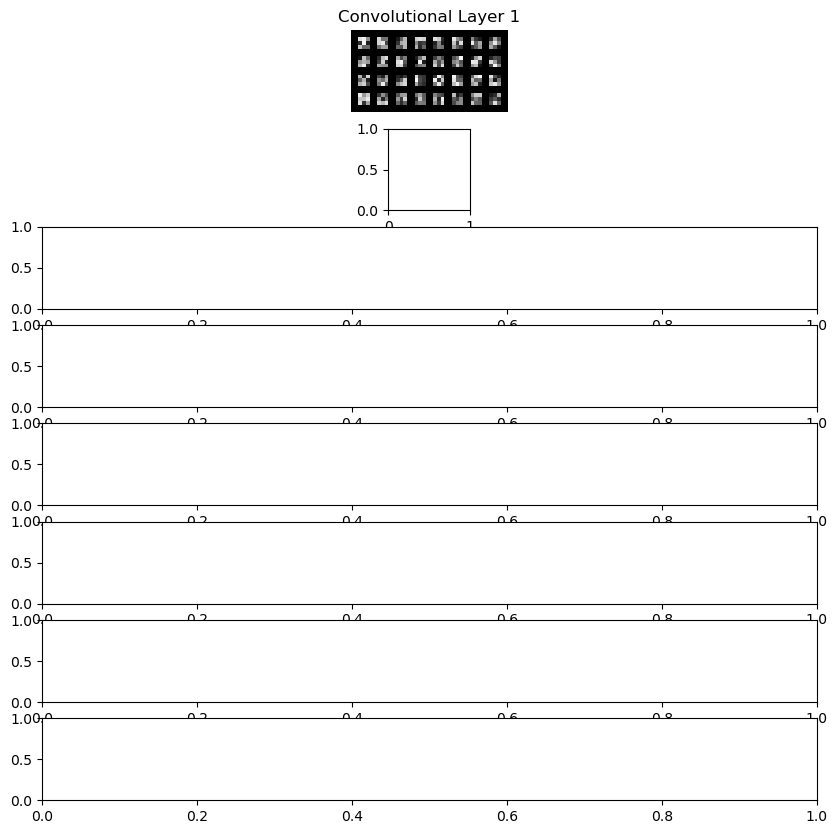

In [40]:
import torch
import torchvision
import matplotlib.pyplot as plt


# Get the convolutional layers
conv_layers = []
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append(module)

# Visualize the filters in each convolutional layer
fig, axes = plt.subplots(len(conv_layers), 1, figsize=(10, 10))
for i, conv_layer in enumerate(conv_layers):
    filters = conv_layer.weight.detach().clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filters = torchvision.utils.make_grid(filters, nrow=8)
    axes[i].imshow(filters.cpu().permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f'Convolutional Layer {i+1}')

plt.tight_layout()
plt.show()


In [37]:
for ix in conv_layers:
    print(ix.weight.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([1, 32, 3, 3])
